## Noblige-1 mud gas plot using Plotly interactive subplots

Noblige-1 is a petroleum exploration well drilled by Woodside Energy Ltd. on the Outer Exmouth Plateau, offshore Western Australia.

This notebook demostrates the following:
1. Importing various data types from various sources (las, text, Excel and PDF files)
2. Cleaning data where required (mostly in Python, some in Excel)
3. Creation of a vsualisation plot of several parameters acquired while drilling the well, and from post-well analysis.


The raw data includes petrophysical logs, mudgas and drilling parameters, and mudgas isotope analysis (from Isotubes).

All data is open-file and publicly available, and was downloaded from https://nopims.dmp.wa.gov.au/nopims

In [1]:
# Import the various modules required

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import lasio
import tabula as tb

In [2]:
# Function to read and clean log, mudgas and drill data

def read_data(logs_fname, mudgas_fname, drilldata_fname, isodata_fname):
    global logs 
    logs = lasio.read(logs_fname).df()
    mudgas_raw = pd.read_csv(mudgas_fname, 
                             sep="\t", 
                             skiprows=20, 
                             header=[0])
    drilldata_raw = pd.read_csv(drilldata_fname, 
                                sep="\t", 
                                skiprows=5, 
                                header=[0, 1])
    global mudgas 
    mudgas = mudgas_raw.replace(-999.25, 
                                np.NaN)
    global drilldata 
    drilldata = drilldata_raw.replace(-999.25, 
                                      np.NaN)
    global isodata
    isodata = pd.read_excel(isodata_fname, 
                            sheet_name="SORTED by DEPTH", 
                            header=[14, 15])

In [3]:
# Read data files

read_data("Data/NOBLIGE_1_22_09_10SCALAR.las", 
          "Data/Noblige_1_Gas_Ascii_2426_4581mMD.txt",
          "Data/Noblige_1_Drill_Data_1343_4581mMD.txt", 
          "Data/Job3997_Noblige_1_final_mud_gas_Isotubes_data_edited.xls")

In [4]:
# Reset log dataframe index

logs.reset_index(inplace=True)

In [5]:
# Assign log, mudgas and drill data curves to variable names

Depth1 = logs['DEPTH']
GR = logs['GR']

Depth2 = mudgas['DEPTH(m)']
TG = mudgas['TOTGAS_MAX(%)']
C1 = mudgas['CHR1C1_AVG(%)']
C2 = mudgas['CHR1C2_AVG(%)']
C3 = mudgas['CHR1C3_AVG(%)']
iC4 = mudgas['CHR1IC4_AVG(%)']
nC4 = mudgas['CHR1NC4_AVG(%)']
iC5 = mudgas['CHR1IC5_AVG(%)']
nC5 = mudgas['CHR1NC5_AVG(%)']
CO2 = mudgas['CO2(%)']
H2S = mudgas['H2S1_AVG(%)']

Depth3 = drilldata['DEPTH']['mMDRT']    # additional indexing required due to 2 header rows
ROP = drilldata['ROP_AVG']['m/hr']
WOB = drilldata['WOB_AVG']['klbs']
MW_IN = drilldata['MWIN']['sg']
MW_OUT = drilldata['MWOUT']['sg']

# Wetness and balance calculation

Wh = (C2+C3+iC4+nC4+iC5+nC5) / (C1+C2+C3+iC4+nC4+iC5+nC5) * 100
Bh = (C1+C2) / (C3+iC4+nC4+iC5+nC5)

# Assign isotope data to variable names

Depth4 = isodata['Depth 1']['Meter']
delta13C_C1 = isodata["d13C1"]['‰']    # additional indexing required due to 2 header rows
delta13C_C2 = isodata["d13C2"]['‰']
delta13C_C3 = isodata["d13C3"]['‰']

# Assigne ethene data to variable name

Ethene = isodata['C2H4']['ppm']

In [6]:
# Read stratigraphy from Well Completion Report (PDF)

strat_table = tb.read_pdf("Data/Noblige_1_WCR_Interpretive_Data.pdf",
                            pages=[13, 14],
                            pandas_options={'header': None})

# Concatenate stratigraphy into one dataframe

for strat in strat_table:
    strat = pd.concat(strat_table)
    
# Export to csv for cleaning in Excel
    
strat.to_csv("Data/Noblige-1_strat_messy.csv", 
             index=False)

In [7]:
# Import stratigraphic picks

Picks = pd.read_csv("Data/Noblige-1_strat_clean.csv")

# Create list of x plot values

Picks_x = []

for i in range(len(Picks)):
        Picks_x.append(250)    # x plot value of 250 (max of GR axis)
    
# Add Picks_x column to Picks dataframe

Picks['picks_x'] = Picks_x

# Assign formation data to variable names

Fm_depth = Picks['Actual Depth (mTVDss MSL)']
Fm_name = Picks['Marker']
Fm_x = Picks['picks_x']

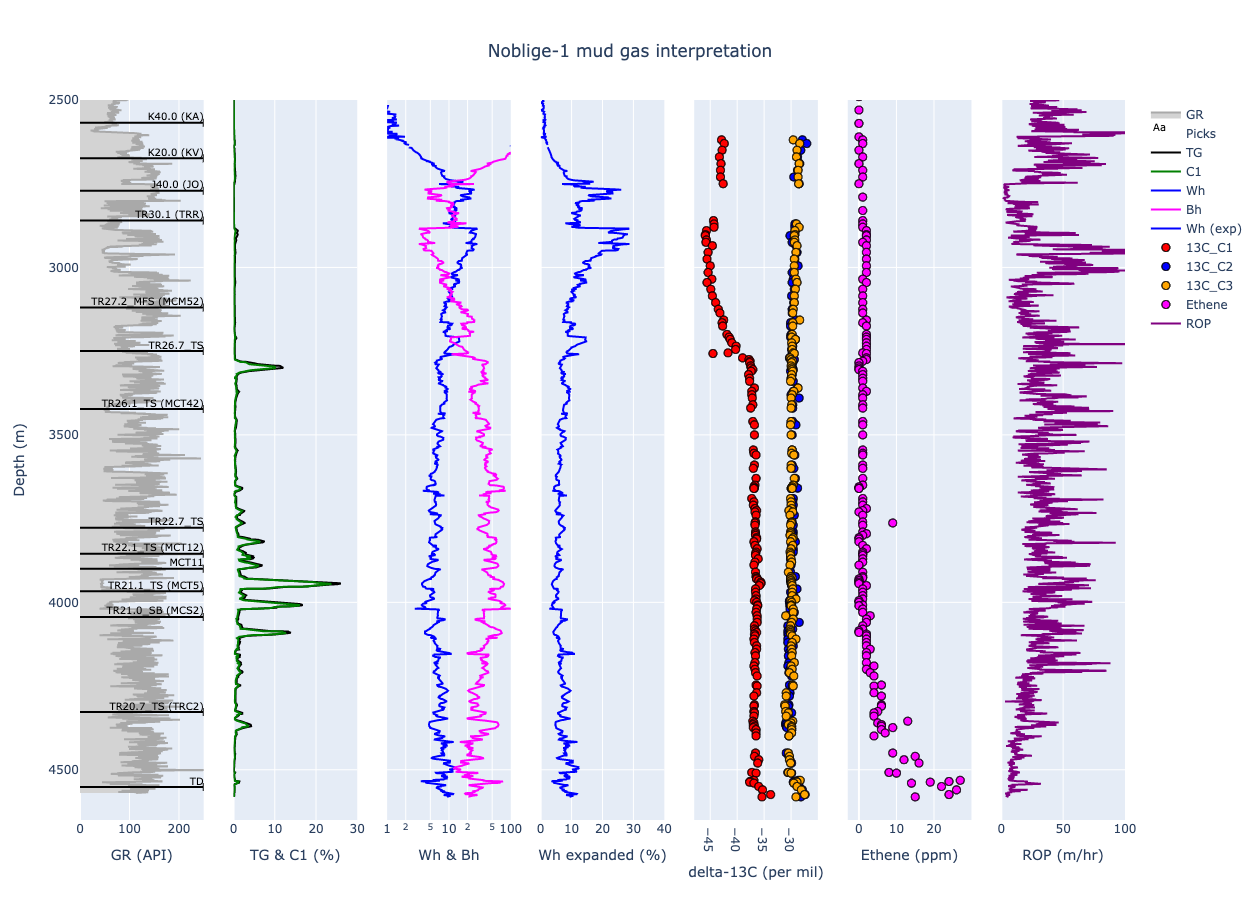

In [8]:
# Configure and display plot with Plotly make_subplots()

fig = make_subplots(rows=1, cols=7, shared_yaxes=True)

# Gamma ray with color fill

fig.add_trace(go.Scatter(x=GR, y=Depth1, 
                         name='GR',
                         line=dict(color='darkgrey'),
                         fill='tozerox',
                         fillcolor = 'lightgrey'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=Fm_x, y=Fm_depth, 
                         name='Picks', 
                         line=dict(color='black'), 
                         mode='text', 
                         error_x=dict(type='constant', 
                                      symmetric=False, 
                                      value=0, valueminus=300, 
                                      color='black'), 
                         text=Fm_name, 
                         textposition='top left', 
                         textfont=dict(color='black'),
                         textfont_size=10), 
              row=1, col=1)

fig.add_trace(go.Scatter(x=TG, y=Depth2, 
                         name='TG', 
                         line=dict(color='black')), 
              row=1, col=2)

fig.add_trace(go.Scatter(x=C1, y=Depth2, 
                         name='C1', 
                         line=dict(color='green')), 
              row=1, col=2)

fig.add_trace(go.Scatter(x=Wh, y=Depth2, 
                         name='Wh', 
                         line=dict(color='blue')), 
              row=1, col=3)

fig.add_trace(go.Scatter(x=Bh, y=Depth2, 
                         name='Bh', 
                         line=dict(color='magenta')), 
              row=1, col=3)

fig.add_trace(go.Scatter(x=Wh, y=Depth2, 
                         name='Wh (exp)', 
                         line=dict(color='blue')), 
              row=1, col=4)

fig.add_trace(go.Scatter(x=delta13C_C1, y=Depth4, 
                         name='13C_C1', 
                         line=dict(color='black'), 
                         mode='markers',
                         marker=dict(size=8, 
                                     line=dict(width=1), 
                                     color='red')), 
              row=1, col=5)

fig.add_trace(go.Scatter(x=delta13C_C2, y=Depth4, 
                         name='13C_C2', 
                         line=dict(color='black'),
                         mode='markers',
                         marker=dict(size=8, 
                                     line=dict(width=1), 
                                     color='blue')), 
              row=1, col=5)

fig.add_trace(go.Scatter(x=delta13C_C3, y=Depth4, 
                         name='13C_C3', 
                         line=dict(color='black'), 
                         mode='markers',
                         marker=dict(size=8, 
                                     line=dict(width=1), 
                                     color='orange')), 
              row=1, col=5)

fig.add_trace(go.Scatter(x=Ethene, y=Depth4, 
                         name='Ethene', 
                         line=dict(color='black'), 
                         mode='markers',
                         marker=dict(size=8, 
                                     line=dict(width=1), 
                                     color='magenta')), 
              row=1, col=6)

fig.add_trace(go.Scatter(x=ROP, y=Depth3, 
                         name='ROP', 
                         line=dict(color='purple')), 
              row=1, col=7)

fig.update_xaxes(title_text='GR (API)', 
                 row=1, col=1,
                 type='linear',
                 range=[0, 250])

fig.update_xaxes(title_text='TG & C1 (%)', 
                 row=1, col=2,
                 type='linear',
                 range=[0, 30])

fig.update_xaxes(title_text='Wh & Bh', 
                 row=1, col=3,
                 type='log',
                 range=[0, 2])

fig.update_xaxes(title_text='Wh expanded (%)', 
                 row=1, col=4,
                 type='linear',
                 range=[0, 40])

fig.update_xaxes(title_text='delta-13C (per mil)', 
                 row=1, col=5,
                 type='linear')

fig.update_xaxes(title_text='Ethene (ppm)', 
                 row=1, col=6,
                 type='linear')

fig.update_xaxes(title_text='ROP (m/hr)', 
                 row=1, col=7,
                 type='linear',
                 range=[0, 100])

fig.update_yaxes(title_text='Depth (m)', 
                 row=1, col=1, 
                 range=[4650, 2500])

fig.update_layout(template='plotly',
                  height=900, 
                  title={'text':'Noblige-1 mud gas interpretation',
                         'y':0.95,
                         'x':0.5,                         
                         'xanchor':'center',                         
                         'yanchor':'top'})
                  
fig.show()
fig.write_html("Noblige-1_mud_gas_plot_interactive.html", 
               include_plotlyjs='cdn')